### Stacking the best regression predictor and the neural network

In [11]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

In [12]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

In [69]:
# Load the data
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
X_train, y_train = prepare_inputs(X_train, y_train)

# Transforming the input
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 
X_tranformed = trans_pipeline.fit_transform(X_combined)

# Split the transformed input back
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [70]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.2, random_state=42)

# Split the training set into two subsets for prediction and blending
X_train_subset1, X_train_subset2, y_train_subset1, y_train_subset2 = \
                                    train_test_split(X_train, y_train, test_size=.3, random_state=42)

In [71]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

# Define first estimator
adaboost_estimator = AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42)

In [72]:
# Train the first estimator on the first subset
adaboost_estimator.fit(X_train_subset1, y_train_subset1)

AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=0.001, loss='linear', n_estimators=100,
         random_state=42)

In [73]:
# Predict with the first estimator on the second subset
prediction_adaboost = adaboost_estimator.predict(X_train_subset2)

In [74]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation


# Define the build function for the second estimator
def build_nn():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the mode
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [75]:
# Define pipeline with scaler for second regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=1000, verbose=1))
])

In [76]:
# Train the second estimator on the first subset
pipeline.fit(X_train_subset1, y_train_subset1)

Epoch 1/1000
814/814 [==============================] - 1s 920us/step - loss: 27.1233
Epoch 2/1000
814/814 [==============================] - 0s 475us/step - loss: 4.1749
Epoch 3/1000
814/814 [==============================] - 0s 485us/step - loss: 3.3275
Epoch 4/1000
814/814 [==============================] - 0s 483us/step - loss: 3.1973
Epoch 5/1000
814/814 [==============================] - 0s 499us/step - loss: 2.8956
Epoch 6/1000
814/814 [==============================] - 0s 473us/step - loss: 3.0839
Epoch 7/1000
814/814 [==============================] - 0s 493us/step - loss: 2.9773
Epoch 8/1000
814/814 [==============================] - 0s 495us/step - loss: 2.6229
Epoch 9/1000
814/814 [==============================] - 0s 487us/step - loss: 2.9708
Epoch 10/1000
814/814 [==============================] - 0s 485us/step - loss: 2.4684
Epoch 11/1000
814/814 [==============================] - 0s 500us/step - loss: 2.3655
Epoch 12/1000
814/814 [==============================] - 0s 49

814/814 [==============================] - 0s 508us/step - loss: 0.3685
Epoch 97/1000
814/814 [==============================] - 0s 462us/step - loss: 0.3373
Epoch 98/1000
814/814 [==============================] - 0s 459us/step - loss: 0.3371
Epoch 99/1000
814/814 [==============================] - 0s 454us/step - loss: 0.3525
Epoch 100/1000
814/814 [==============================] - 0s 446us/step - loss: 0.3168
Epoch 101/1000
814/814 [==============================] - 0s 463us/step - loss: 0.3541
Epoch 102/1000
814/814 [==============================] - 0s 457us/step - loss: 0.3409
Epoch 103/1000
814/814 [==============================] - 0s 467us/step - loss: 0.3181
Epoch 104/1000
814/814 [==============================] - 0s 461us/step - loss: 0.3429
Epoch 105/1000
814/814 [==============================] - 0s 468us/step - loss: 0.3362
Epoch 106/1000
814/814 [==============================] - 0s 455us/step - loss: 0.3141
Epoch 107/1000
814/814 [==============================] - 0s 

814/814 [==============================] - 0s 479us/step - loss: 0.2327
Epoch 191/1000
814/814 [==============================] - 0s 449us/step - loss: 0.2427
Epoch 192/1000
814/814 [==============================] - 0s 439us/step - loss: 0.2140
Epoch 193/1000
814/814 [==============================] - 0s 443us/step - loss: 0.2084
Epoch 194/1000
814/814 [==============================] - 0s 452us/step - loss: 0.2405
Epoch 195/1000
814/814 [==============================] - 0s 452us/step - loss: 0.2227
Epoch 196/1000
814/814 [==============================] - 0s 456us/step - loss: 0.2273
Epoch 197/1000
814/814 [==============================] - 0s 474us/step - loss: 0.1958
Epoch 198/1000
814/814 [==============================] - 0s 522us/step - loss: 0.2075
Epoch 199/1000
814/814 [==============================] - 0s 494us/step - loss: 0.2008
Epoch 200/1000
814/814 [==============================] - 0s 459us/step - loss: 0.2105
Epoch 201/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 550us/step - loss: 0.1371
Epoch 285/1000
814/814 [==============================] - 0s 507us/step - loss: 0.1569
Epoch 286/1000
814/814 [==============================] - 0s 512us/step - loss: 0.1625
Epoch 287/1000
814/814 [==============================] - 0s 496us/step - loss: 0.1558
Epoch 288/1000
814/814 [==============================] - 0s 481us/step - loss: 0.1440
Epoch 289/1000
814/814 [==============================] - 0s 524us/step - loss: 0.1373
Epoch 290/1000
814/814 [==============================] - 0s 508us/step - loss: 0.1643
Epoch 291/1000
814/814 [==============================] - 0s 546us/step - loss: 0.1353
Epoch 292/1000
814/814 [==============================] - 0s 538us/step - loss: 0.1470
Epoch 293/1000
814/814 [==============================] - 0s 582us/step - loss: 0.1522
Epoch 294/1000
814/814 [==============================] - 0s 521us/step - loss: 0.1480
Epoch 295/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 520us/step - loss: 0.1048
Epoch 379/1000
814/814 [==============================] - 0s 465us/step - loss: 0.0948
Epoch 380/1000
814/814 [==============================] - 0s 453us/step - loss: 0.1131
Epoch 381/1000
814/814 [==============================] - 0s 444us/step - loss: 0.0989
Epoch 382/1000
814/814 [==============================] - 0s 462us/step - loss: 0.1098
Epoch 383/1000
814/814 [==============================] - 0s 449us/step - loss: 0.0922
Epoch 384/1000
814/814 [==============================] - 0s 459us/step - loss: 0.0939
Epoch 385/1000
814/814 [==============================] - 0s 461us/step - loss: 0.0985
Epoch 386/1000
814/814 [==============================] - 0s 445us/step - loss: 0.1006
Epoch 387/1000
814/814 [==============================] - 0s 455us/step - loss: 0.0980
Epoch 388/1000
814/814 [==============================] - 0s 452us/step - loss: 0.0908
Epoch 389/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 514us/step - loss: 0.0615
Epoch 473/1000
814/814 [==============================] - 0s 551us/step - loss: 0.0578
Epoch 474/1000
814/814 [==============================] - 0s 536us/step - loss: 0.0565
Epoch 475/1000
814/814 [==============================] - 0s 476us/step - loss: 0.0600
Epoch 476/1000
814/814 [==============================] - 0s 442us/step - loss: 0.0661
Epoch 477/1000
814/814 [==============================] - 0s 444us/step - loss: 0.0578
Epoch 478/1000
814/814 [==============================] - 0s 447us/step - loss: 0.0580
Epoch 479/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0592
Epoch 480/1000
814/814 [==============================] - 0s 466us/step - loss: 0.0592
Epoch 481/1000
814/814 [==============================] - 0s 440us/step - loss: 0.0565
Epoch 482/1000
814/814 [==============================] - 0s 448us/step - loss: 0.0648
Epoch 483/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 570us/step - loss: 0.0397
Epoch 567/1000
814/814 [==============================] - 0s 555us/step - loss: 0.0372
Epoch 568/1000
814/814 [==============================] - 0s 572us/step - loss: 0.0411
Epoch 569/1000
814/814 [==============================] - 0s 567us/step - loss: 0.0354
Epoch 570/1000
814/814 [==============================] - 0s 561us/step - loss: 0.0333
Epoch 571/1000
814/814 [==============================] - 0s 582us/step - loss: 0.0435
Epoch 572/1000
814/814 [==============================] - 0s 557us/step - loss: 0.0349
Epoch 573/1000
814/814 [==============================] - 0s 503us/step - loss: 0.0304
Epoch 574/1000
814/814 [==============================] - 0s 469us/step - loss: 0.0358
Epoch 575/1000
814/814 [==============================] - 0s 459us/step - loss: 0.0347
Epoch 576/1000
814/814 [==============================] - 0s 459us/step - loss: 0.0312
Epoch 577/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 477us/step - loss: 0.0286
Epoch 661/1000
814/814 [==============================] - 0s 452us/step - loss: 0.0231
Epoch 662/1000
814/814 [==============================] - 0s 437us/step - loss: 0.0244
Epoch 663/1000
814/814 [==============================] - 0s 450us/step - loss: 0.0238
Epoch 664/1000
814/814 [==============================] - 0s 443us/step - loss: 0.0255
Epoch 665/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0218
Epoch 666/1000
814/814 [==============================] - 0s 440us/step - loss: 0.0237
Epoch 667/1000
814/814 [==============================] - 0s 451us/step - loss: 0.0212
Epoch 668/1000
814/814 [==============================] - 0s 438us/step - loss: 0.0229
Epoch 669/1000
814/814 [==============================] - 0s 436us/step - loss: 0.0259
Epoch 670/1000
814/814 [==============================] - 0s 450us/step - loss: 0.0248
Epoch 671/1000
814/814 [==============================] - 

814/814 [==============================] - 1s 668us/step - loss: 0.0218
Epoch 755/1000
814/814 [==============================] - 0s 469us/step - loss: 0.0247
Epoch 756/1000
814/814 [==============================] - 0s 494us/step - loss: 0.0157
Epoch 757/1000
814/814 [==============================] - 0s 466us/step - loss: 0.0190
Epoch 758/1000
814/814 [==============================] - 0s 543us/step - loss: 0.0262
Epoch 759/1000
814/814 [==============================] - 0s 522us/step - loss: 0.0262
Epoch 760/1000
814/814 [==============================] - 0s 549us/step - loss: 0.0224
Epoch 761/1000
814/814 [==============================] - 0s 518us/step - loss: 0.0179
Epoch 762/1000
814/814 [==============================] - 0s 522us/step - loss: 0.0171
Epoch 763/1000
814/814 [==============================] - 0s 512us/step - loss: 0.0217
Epoch 764/1000
814/814 [==============================] - 0s 540us/step - loss: 0.0213
Epoch 765/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 508us/step - loss: 0.0213
Epoch 849/1000
814/814 [==============================] - 0s 456us/step - loss: 0.0233
Epoch 850/1000
814/814 [==============================] - 0s 455us/step - loss: 0.0219
Epoch 851/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0205
Epoch 852/1000
814/814 [==============================] - 0s 442us/step - loss: 0.0172
Epoch 853/1000
814/814 [==============================] - 0s 453us/step - loss: 0.0219
Epoch 854/1000
814/814 [==============================] - 0s 440us/step - loss: 0.0191
Epoch 855/1000
814/814 [==============================] - 0s 434us/step - loss: 0.0215
Epoch 856/1000
814/814 [==============================] - 0s 441us/step - loss: 0.0169
Epoch 857/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0216
Epoch 858/1000
814/814 [==============================] - 0s 450us/step - loss: 0.0183
Epoch 859/1000
814/814 [==============================] - 

814/814 [==============================] - 0s 478us/step - loss: 0.0225
Epoch 943/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0170
Epoch 944/1000
814/814 [==============================] - 0s 440us/step - loss: 0.0208
Epoch 945/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0189
Epoch 946/1000
814/814 [==============================] - 0s 429us/step - loss: 0.0164
Epoch 947/1000
814/814 [==============================] - 0s 434us/step - loss: 0.0200
Epoch 948/1000
814/814 [==============================] - 0s 439us/step - loss: 0.0224
Epoch 949/1000
814/814 [==============================] - 0s 431us/step - loss: 0.0221
Epoch 950/1000
814/814 [==============================] - 0s 453us/step - loss: 0.0191
Epoch 951/1000
814/814 [==============================] - 0s 436us/step - loss: 0.0188
Epoch 952/1000
814/814 [==============================] - 0s 437us/step - loss: 0.0177
Epoch 953/1000
814/814 [==============================] - 

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001AD1E5D8C18>)])

In [77]:
# Predict with the second estimator on the second subset
prediction_nn = pipeline.predict(X_train_subset2)

350/350 [==============================] - 0s 527us/step


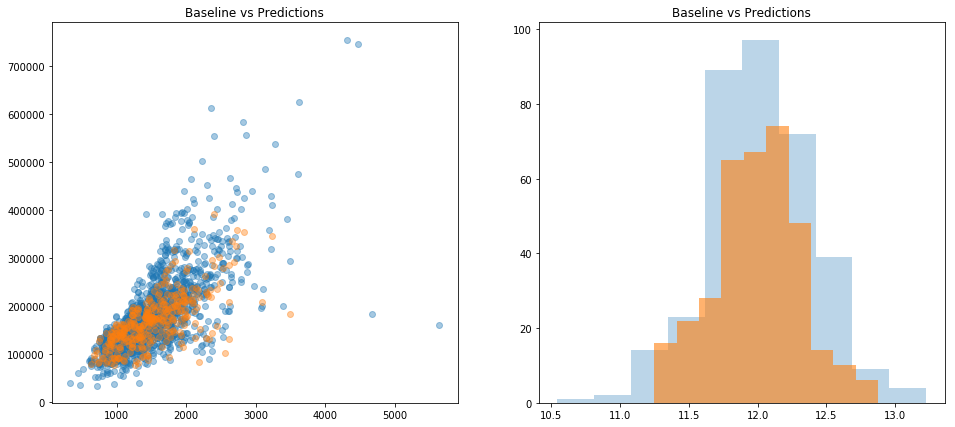

R2-score: 0.802477890598
RMSE (log): 0.1688907225068115


In [78]:
plot_benchmark(X_train_subset2, y_train_subset2, prediction_nn)

In [79]:
from sklearn.ensemble import BaggingRegressor

# Not we define a bagging ensemble for the blending
bagging_estimator = BaggingRegressor(Ridge(alpha=10, random_state=42, solver='cholesky', tol=0.001), n_estimators=500,
        max_samples=200, bootstrap=True)

In [80]:
# This blender now we train on the predictions of the first layer
X_blended = np.column_stack((prediction_nn, prediction_adaboost))

bagging_estimator.fit(X_blended, y_train_subset2)

BaggingRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=200, n_estimators=500, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [81]:
# And now we use the stack to make a prediction on unseen data
test_prediction_ada = adaboost_estimator.predict(X_test)
test_prediction_nn = pipeline.predict(X_test)

X_test_blended = np.column_stack((test_prediction_nn, test_prediction_ada))
y_predicted = bagging_estimator.predict(X_test_blended)

292/292 [==============================] - 0s 268us/step


In [83]:
print_benchmark(y_test, y_predicted)

R2-score: 0.858101776321
RMSE (log): 0.14970367003103172
